In [5]:
import torch as t
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
from typing import Callable
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

t.__version__

'1.5.1'

In [6]:
a_np = np.array([[1,2,3],[4,5,6]])
a_pt = t.tensor([[1,2,3],[4,5,6]])

a_np, a_pt

(array([[1, 2, 3],
        [4, 5, 6]]),
 tensor([[1, 2, 3],
         [4, 5, 6]]))

In [7]:
x = a_pt[0].type(t.float32)
y = a_pt[1].type(t.float32)

x.shape, x.dim()

(torch.Size([3]), 1)

In [8]:
x+y, x*y

(tensor([5., 7., 9.]), tensor([ 4., 10., 18.]))

In [9]:
x.mean(), x.std(), x.max(), x.argmax()

(tensor(2.), tensor(1.), tensor(3.), tensor(2))

In [10]:
x = t.randn((2,3,1,10,10))

In [11]:
x.squeeze().shape, x.unsqueeze(dim=4).shape

(torch.Size([2, 3, 10, 10]), torch.Size([2, 3, 1, 10, 1, 10]))

In [12]:
x = t.arange(0, 100).reshape((2,5,10))

In [13]:
iris = datasets.load_iris()
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [14]:
iris['data'].shape, iris['data'].dtype

((150, 4), dtype('float64'))

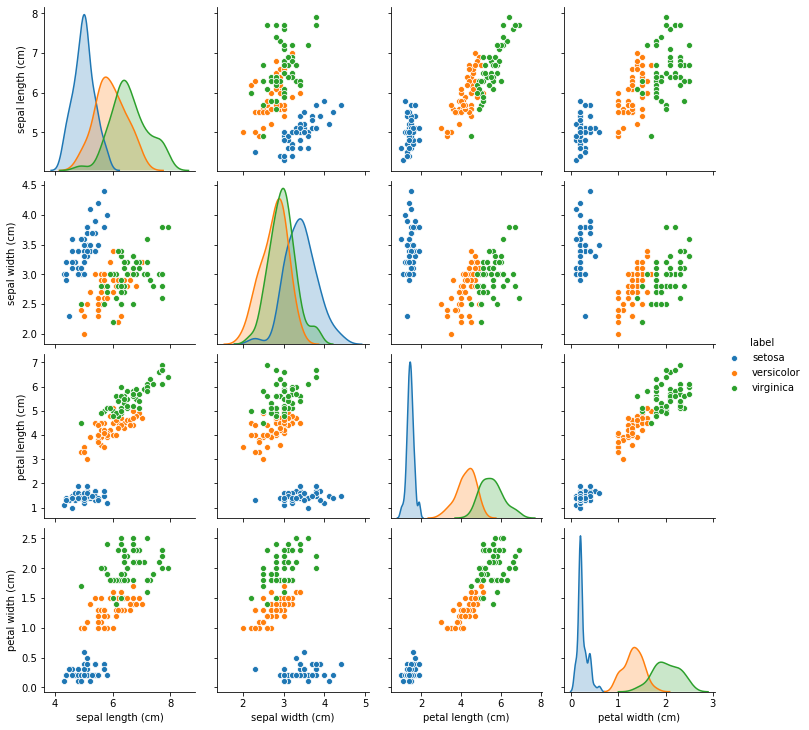

In [15]:
features_df = pd.DataFrame(iris['data'], columns=iris['feature_names'])
features_df['label'] = iris['target_names'][iris['target']]

sns.pairplot(features_df, hue='label')

In [16]:
p_processed = (iris['data']-iris['data'].mean())

labels = iris['target']

train_data, test_data, train_labels, test_labels = train_test_split(p_processed, labels, test_size=1/3)

In [17]:
data = {
    'train': t.tensor(train_data, dtype=t.float32),
    'test': t.tensor(test_data, dtype=t.float32)
}
labels = {
    'train': t.tensor(train_labels, dtype=t.long),
    'test': t.tensor(test_labels, dtype=t.long)
}

In [18]:
class MLP(nn.Module):
    
    def __init__(
        self,
        input_dim: int,
        hidden_layer_dim: int,
        output_dim: int,
        activation_fn: Callable[[t.Tensor], t.Tensor] = F.relu
    ):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_layer_dim)
        self.fc2 = nn.Linear(hidden_layer_dim, output_dim)
        self.activation_fn = activation_fn
    
    def forward(self, x: t.Tensor) -> t.Tensor:
        x = self.fc1(x)
        x = self.activation_fn(x)
        x = self.fc2(x)
        return x
    
def accuracy(pred: t.FloatTensor, targets: t.LongTensor) -> float:
    if (pred.shape[0] != targets.shape[0]):
        raise ValueError(f"prediction tensor was of shape {pred.shape[0]}"f" but expected shape {targets.shape[0]}")
        
    correct = (pred.argmax(1) == targets).sum().item()
    return correct / pred.shape[0]

def check_accuracy(probs: t.FloatTensor,
                   labels: t.LongTensor,
                   expected_accuracy: float):
    actual_accuracy = float(accuracy(probs, labels))
    assert actual_accuracy == expected_accuracy, f"Expected accuracy to be {expected_accuracy} but was {actual_accuracy}"

check_accuracy(t.tensor([[0, 1],
                             [0, 1],
                             [0, 1],
                             [0, 1],
                             [0, 1]]),
               t.ones(5, dtype=t.long),
               1.0)
check_accuracy(t.tensor([[1, 0],
                             [0, 1],
                             [0, 1],
                             [0, 1],
                             [0, 1]]),
               t.ones(5, dtype=t.long),
               0.8)
check_accuracy(t.tensor([[1, 0],
                             [1, 0],
                             [0, 1],
                             [0, 1],
                             [0, 1]]),
               t.ones(5, dtype=t.long),
               0.6)
check_accuracy(t.tensor([[1, 0],
                             [1, 0],
                             [1, 0],
                             [1, 0],
                             [1, 0]]),
               t.ones(5, dtype=t.long),
               0.0)
print("All test cases passed")

All test cases passed


In [19]:
features = 4
hidden_layer_dim = 100
class_count = 3

model = MLP(features, hidden_layer_dim, class_count)

In [20]:
logits = model.forward(data['train'])

loss = F.cross_entropy(logits, labels['train'])
loss.backward()

In [21]:
### TRAINING LOOP ###

model = MLP(features, hidden_layer_dim, class_count)
optimiser = optim.SGD(model.parameters(), lr = 0.05)

for epoch in range(0, 200):
    
    optimiser.zero_grad()    
    logits = model.forward(data['train'])

    loss = F.cross_entropy(logits, labels['train'])
    loss.backward()
    
    optimiser.step()
    
    if epoch % 20 == 0:
        print("epoch: {}, train acc: {:2.2f}, loss: {:5.5f}".format(
            epoch,
            accuracy(logits, labels['train']),
            loss.item()
        ))

out = model.forward(data['test'])
test_accuracy = accuracy(out, labels['test'])
print("test acc: {:2.2f}".format(test_accuracy))

epoch: 0, train acc: 0.36, loss: 1.10360
epoch: 20, train acc: 0.93, loss: 0.41632
epoch: 40, train acc: 0.93, loss: 0.31838
epoch: 60, train acc: 0.93, loss: 0.26697
epoch: 80, train acc: 0.93, loss: 0.23360
epoch: 100, train acc: 0.94, loss: 0.20953
epoch: 120, train acc: 0.94, loss: 0.19125
epoch: 140, train acc: 0.94, loss: 0.17670
epoch: 160, train acc: 0.94, loss: 0.16494
epoch: 180, train acc: 0.95, loss: 0.15525
test acc: 1.00


In [22]:
lr = [1e1, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
acc = []

for l in lr:
    m = MLP(features, hidden_layer_dim, class_count)
    o = optim.SGD(m.parameters(), lr = l)
    
    for epoch in range(0, 200):
    
        o.zero_grad()    
        logits = m.forward(data['train'])

        loss = F.cross_entropy(logits, labels['train'])
        loss.backward()

        o.step()
    
    out = m.forward(data['test'])
    test_accuracy = accuracy(out, labels['test'])
    print("lr: {}, test acc: {:2.2f}".format(l, test_accuracy))
    
    acc.append(test_accuracy)

lr: 10.0, test acc: 0.36
lr: 1, test acc: 1.00
lr: 0.1, test acc: 1.00
lr: 0.01, test acc: 1.00
lr: 0.001, test acc: 0.98
lr: 0.0001, test acc: 0.28
lr: 1e-05, test acc: 0.34
lr: 1e-06, test acc: 0.28
lr: 1e-07, test acc: 0.36


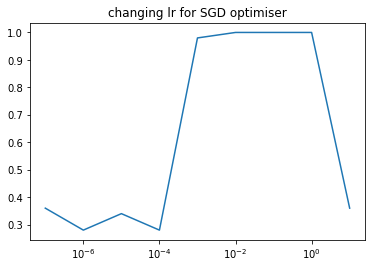

In [23]:
fig, ax = plt.subplots()
ax.set_title("changing lr for SGD optimiser")
ax.set_xscale('log')
ax.plot(lr, acc)

In [24]:
### TENSORBOARD TRAINING LOOP ###

model = MLP(features, hidden_layer_dim, class_count)
optimiser = optim.SGD(model.parameters(), lr = 0.05)

writer = SummaryWriter('logs', flush_secs=5)

for epoch in range(0, 200):
    
    optimiser.zero_grad()    
    logits = model.forward(data['train'])

    loss = F.cross_entropy(logits, labels['train'])
    loss.backward()
    
    optimiser.step()
    
    train_accuracy = accuracy(logits, labels['train']) * 100
    writer.add_scalar('accuracy/train', train_accuracy, epoch)
    writer.add_scalar('loss/train', loss.item(), epoch)

writer.close()